In [1]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.extmath import cartesian
from scipy.linalg import block_diag

In [2]:
from theano import *
import theano.tensor as T
from theano import function

In [3]:
import argparse
parser = argparse.ArgumentParser(description='Process some integers.')
parser.add_argument('-f') # jupyter
parser.add_argument('--n_documents', type=int, default=10,
                   help='number of documents to collect data for')
args = parser.parse_args()
n_articles = args.n_documents

In [4]:
n_articles = 100

# Distances between sentences

In [7]:
# load embeddings and metadata and
# compute distances between sentences
def get_distances(model, dataset):
    input_matrix_file = "data/%s/%s_%s_%d.npy" %(dataset, dataset, model, n_articles)
    input_data_file = "data/%s/%s_reformatted_%d.csv" %(dataset, dataset, n_articles)
    # load data
    df = pd.read_csv(input_data_file)
    # load embeddings
    embeddings = np.load(input_matrix_file)
    distances = 1 - cosine_similarity(embeddings, embeddings)
    displacements = embeddings[1:] - embeddings[:-1]
    return df, distances, displacements

df, distances, displacements = get_distances("skipthoughts", "wiki")

## Distances between not (necessarily) adjacent sentences

How similar do sentences from the same document tend to be? How similar do sentences from different documents tend to be?

The similarity due to being in the same document gives us some sense of overall topic similarity.

Take any two unique sentences in the dataset, either from the same document or different documents, and measure the distance between them.

In [8]:
distances.shape

(13845, 13845)

In [14]:
%%time
def make_block(N):
    x = np.ones((N, N))
    x.dtype = int
    return x

def get_doc_masks(df, distances):
    # need to make this parallel so that it's at least as fast as (e.g.) cosine similarity
    number_of_sentences_per_doc = df.groupby("doc_id").apply(lambda x: len(x))
    document_blocks = number_of_sentences_per_doc.apply(make_block)
    same_doc_mask = block_diag(*document_blocks)
    # TODO if i change to type bool, size of array changes: wtf?
    diff_doc_mask = 1 - same_doc_mask
    # upper diagonals, so we ignore same sentences
    same_doc_mask = np.triu(same_doc_mask, 1)
    diff_doc_mask = np.triu(diff_doc_mask, 1)
    return same_doc_mask, diff_doc_mask

# def within_vs_across_docs(df):
#     # pairs of indices
#     product = cartesian((df.doc_id,df.doc_id))
#     # are they in the same document?
#     same_doc, diff_doc = get_doc_masks(df, distances)
#     # mask by whether distances are in the same document
#     same_doc = distances[same_doc]
#     diff_doc = distances[diff_doc]
#     # create dataframe
#     pair_types = (["Same Document" for i in range(len(same_doc_distances))] +
#                   ["Different Document" for i in range(len(diff_doc_distances))])
#     doc_dist_df = pd.DataFrame({"pair_type": pair_types,
#                                 "distance": np.concatenate((same_doc_distances,
#                                                             diff_doc_distances), axis=None)})
#     # get means
#     doc_dist_means = doc_dist_df.groupby("pair_type").mean()
#     return doc_dist_means, doc_dist_df

# doc_dist_means, doc_dist_df = within_vs_across_docs(df)
# doc_dist_means
# get_same_doc_mask(df, distances)

same_doc_mask, diff_doc_mask = get_doc_masks(df, distances)
# # mask by whether distances are in the same document
# same_doc = np.mean(distances[same_doc])
# diff_doc = np.mean(distances[diff_doc])

## TODO wtf?!!
same_mean = np.sum(np.multiply(distances, same_doc_mask)) / np.sum(same_doc_mask)
diff_mean = np.sum(np.multiply(distances, diff_doc_mask)) / np.sum(diff_doc_mask)
print(same_mean)
print(diff_mean)

-331683.12697645713
-331683.1269720403
CPU times: user 2.01 s, sys: 1.94 s, total: 3.96 s
Wall time: 3.96 s


## Distances between adjacent sentences

Here's where we start talking about trajectories, at least to some extent. What's the pacing throughout the discourse? When do we make bigger or smaller moves through sentence vector space?

Position in the paragraph might affect the distance between adjacent sentences:
* accross a paragraph boundary (last of one paragraph, first of next)
* paragraph-internal
* first two sentences
* last two sentences

In [5]:
def get_same_par_mask(df, distances):
    # pairs of indices
    product = cartesian((df.par_id,df.par_id))
    # are they in the same document?
    same_doc_mask = product[:,0] == product[:,1]
    same_doc_mask.shape = distances.shape
    return same_doc_mask

def get_first_mask(df, distances):
    # pairs of indices
    product = cartesian((df.s_in_par,df.s_in_par))
    # are they first?
    first_mask = product[:,0] == 0
    first_mask.shape = distances.shape
    return first_mask

def is_last_in_par(i, df):
    if (i == (df.shape[0]-1)):
        return True
    else:
        # next sentence is a different paragraph
        return df.par_id[i+1] != df.par_id[i]
    
def get_last_mask(df, distances):
    product = cartesian((df.s_id,df.s_id))
    last_mask = np.array([is_last_in_par(i, df) for i in product[:,1]])
    last_mask.shape = distances.shape
    return last_mask

def within_vs_across_par(df, distances, details = False):
    product = cartesian((df.s_id,df.s_id))
    adjacent = (product[:,1] - product[:,0]) == 1
    adjacent.shape = distances.shape
    
    # mask to get adjacent sentences in the same document
    adjacent = np.multiply(get_same_doc_mask(df, distances), adjacent)
    
    # mask to get adjacent sentences in the same paragraph
    same_par_mask = get_same_par_mask(df, distances)
    within_par_mask = np.multiply(same_par_mask, adjacent)
    within_par_distances = distances[within_par_mask == 1]
    across_par_mask = np.multiply(1 - same_par_mask, adjacent)
    across_par_distances = distances[across_par_mask == 1]
    
    # TODO make this more faster
    if (details):
    
        # mask to get adjacent sentences in the same paragraph:
        #     - at the beginning of the paragraph
        #     - in the middle of the paragraph
        #     - at the end of the paragraph
        first_mask = get_first_mask(df, distances)
        last_mask = get_last_mask(df, distances)
        internal_mask = (1 - (first_mask + last_mask))
        first_mask = np.multiply(first_mask, within_par_mask)
        internal_mask = np.multiply(internal_mask, within_par_mask)
        last_mask = np.multiply(last_mask, within_par_mask)
        first_distances = distances[first_mask == 1]
        internal_distances = distances[internal_mask == 1]
        last_distances = distances[last_mask == 1]
        
        pair_types = (["Within Paragraph (First)" for i in range(len(first_distances))] +
                      ["Within Paragraph (Internal)" for i in range(len(internal_distances))] +
                      ["Within Paragraph (Last)" for i in range(len(last_distances))] +
                      ["Across Paragraphs" for i in range(len(across_par_distances))])
        distances = np.concatenate((first_distances,
                                    internal_distances,
                                    last_distances,
                                    across_par_distances), axis=None)
    else:
        pair_types = (["Within Paragraph" for i in range(len(within_par_distances))] +
                      ["Across Paragraphs" for i in range(len(across_par_distances))])
        distances = np.concatenate((within_par_distances, across_par_distances), axis=None)

    # create dataframe
    par_dist_df = pd.DataFrame({"pair_type": pair_types,
                                "distance": distances})
    # get means
    par_dist_means = par_dist_df.groupby("pair_type").mean()
    
    return par_dist_means, par_dist_df

par_dist_means, par_dist_df = within_vs_across_par(df, distances)
par_dist_means

,distance
pair_type,
Across Paragraphs,0.332698
Within Paragraph,0.276481


In [6]:
# for within paragraph sentences, could be:
#     - paragraph-internal
#     - first two sentences
#     - last two sentences

par_details_dist_means, par_details_dist_df = within_vs_across_par(df, distances, details = True)
par_details_dist_means

KeyboardInterrupt: 

In [ ]:
par_details_dist_df
dataset = "wiki"
model = "skipthoughts"
distances_matrix_filename = "data/%s/distances_%s_%s_%d.npy" %(dataset, dataset, model, n_articles)
np.save(distances_matrix_filename, par_details_dist_df)

## R visualization

In [5]:
# %load_ext rpy2.ipython

In [6]:
# %%R
# library(tidyverse)
# library(Hmisc)
# library(ggthemes)

/home/erindb/miniconda2/envs/dod/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntime

In [7]:
# %%R -i doc_dist_means
# doc_dist_means

/home/erindb/miniconda2/envs/dod/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


                    distance
Different Document 0.4210159
Same Document      0.3948175


/home/erindb/miniconda2/envs/dod/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 4.17 x 2.78 in image

  warnings.warn(x, RRuntimeWarning)


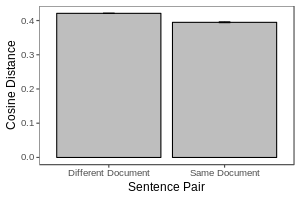

In [8]:
# %%R -i doc_dist_df -w 300 -h 200 -u px
# p = doc_dist_df %>%
# ggplot(aes(x = pair_type, y = distance)) +
# stat_summary(fun.y = mean, geom = "bar", fill = "gray", colour = "black") +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", colour="black", width = 0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(12)
# print(p)
# ggsave("within_vs_across_documents.png")

/home/erindb/miniconda2/envs/dod/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 2.78 x 2.78 in image

  warnings.warn(x, RRuntimeWarning)


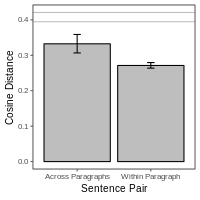

In [9]:
# %%R -i par_dist_df -w 200 -h 200 -u px
# p = par_dist_df %>%
# ggplot(., aes(x = pair_type, y = distance)) +
# geom_hline(yintercept = doc_dist_means["Different Document", "distance"], colour="gray") +
# geom_hline(yintercept = doc_dist_means["Same Document", "distance"], colour="gray") +
# stat_summary(fun.y = mean, geom = "bar", fill="gray", colour="black") +
# stat_summary(fun.data = mean_cl_boot,
#              geom = "errorbar",
#              colour="black",
#              width=0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(10)
# print(p)
# ggsave("adjacent_sentences_within_and_across_paragraphs.png")

/home/erindb/miniconda2/envs/dod/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 5.56 x 2.78 in image

  warnings.warn(x, RRuntimeWarning)


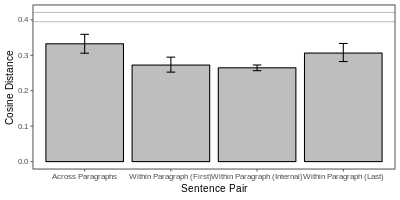

In [21]:
# %%R -i par_details_dist_df -w 400 -h 200 -u px
# p = par_details_dist_df %>%
# ggplot(., aes(x = pair_type, y = distance)) +
# geom_hline(yintercept = doc_dist_means["Different Document", "distance"], colour="gray") +
# geom_hline(yintercept = doc_dist_means["Same Document", "distance"], colour="gray") +
# stat_summary(fun.y = mean, geom = "bar", fill="gray", colour="black") +
# stat_summary(fun.data = mean_cl_boot,
#              geom = "errorbar",
#              colour="black",
#              width=0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(10)
# print(p)
# ggsave("adjacent_sentences_more_details.png")